In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4571cb4a64af88e7ccdc8db4f58b336a0c6f0e72a2fc8b02a4fcd1471b30c518
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import math

from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch
from torch.cuda.amp import autocast, GradScaler

try:
    from torchmetrics.classification import BinaryAccuracy
except:
    !pip3 install -q torchmetrics
    from torchmetrics.classification import BinaryAccuracy
    

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 35
DEVICE

device(type='cpu')

In [4]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
directory_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
dataset = ImageFolder(root=directory_path, transform=trans)

In [6]:
print(dataset.class_to_idx, len(dataset))

{'no': 0, 'yes': 1} 253


In [7]:
train_data_size = math.floor(.8 * len(dataset))
validation_data_size = len(dataset) - train_data_size

print(f'Number of training samples: {train_data_size}')
print(f'Number of validation samples: {validation_data_size}')

Number of training samples: 202
Number of validation samples: 51


In [8]:
# Spliting our data into train and validation parts
train_dataset, validation_dataset = random_split(dataset, [train_data_size, validation_data_size])
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

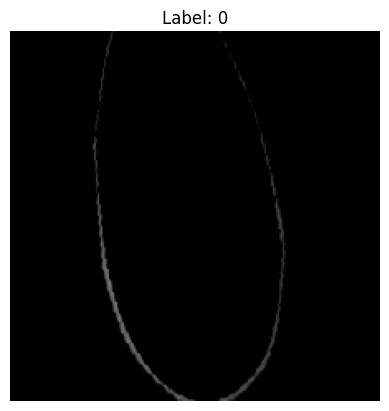

In [9]:
# Preview a Batch of data

images, labels = next(iter(train_data_loader))
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [10]:
def get_model():
    model = EfficientNet.from_pretrained('efficientnet-b0')
    # Freezing all layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Unfreezing the last conv layer
    for param in  model._blocks[-1].parameters():
        param.requires_grad = True
    # Changing the models heas
    model._fc = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(model._fc.in_features, 1),
        nn.Sigmoid()  # binary classification activation function
    )
    return model

model = get_model()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 96.9MB/s]

Loaded pretrained weights for efficientnet-b0


In [14]:
loss_function = nn.BCELoss()
params = list(model._blocks[-1].parameters()) + list(model._fc.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)
accuracy_fn = BinaryAccuracy()

In [15]:
def train_step(model, train_loader, loss_fn, optimizer, accuracy_fn, device):
    train_accuracy, train_loss = 0, 0
    model.train()
    model.to(device)

    for X, y in train_loader:
        X, y = X.to(device), y.to(device).float().unsqueeze(1)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        acc = accuracy_fn((y_pred > 0.5).int(), y.int())
        train_accuracy += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}%')

def test_step(model, val_loader, loss_fn, accuracy_fn, device):
    test_acc, test_loss = 0, 0
    model.eval()
    model.to(device)

    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            
            accuracy_fn.update((y_pred > 0.5), y)

            test_loss += loss.item()
            
            
    avg_loss = test_loss / len(val_loader)
    acc = accuracy_fn.compute().item()
    accuracy_fn.reset()
    print(f'Val Loss: {avg_loss:.2f} | Val Accuracy: {acc:.2f}%')

# The main Training loop 
for e in tqdm(range(EPOCHS)):
    print(f'EPOCH ---- {e + 1}')
    train_step(model, train_data_loader, loss_function, optimizer, accuracy_fn, DEVICE)
    test_step(model, val_data_loader, loss_function, accuracy_fn, DEVICE)

  0%|          | 0/35 [00:00<?, ?it/s]

EPOCH ---- 1
Train Loss: 0.690 | Train Accuracy: 0.53%


  3%|▎         | 1/35 [00:20<11:51, 20.91s/it]

Val Loss: 0.70 | Val Accuracy: 0.51%
EPOCH ---- 2
Train Loss: 0.672 | Train Accuracy: 0.60%


  6%|▌         | 2/35 [00:36<09:39, 17.57s/it]

Val Loss: 0.70 | Val Accuracy: 0.57%
EPOCH ---- 3
Train Loss: 0.654 | Train Accuracy: 0.65%


  9%|▊         | 3/35 [00:51<08:46, 16.47s/it]

Val Loss: 0.69 | Val Accuracy: 0.62%
EPOCH ---- 4
Train Loss: 0.636 | Train Accuracy: 0.73%


 11%|█▏        | 4/35 [01:06<08:14, 15.95s/it]

Val Loss: 0.70 | Val Accuracy: 0.64%
EPOCH ---- 5
Train Loss: 0.614 | Train Accuracy: 0.78%


 14%|█▍        | 5/35 [01:22<07:56, 15.89s/it]

Val Loss: 0.70 | Val Accuracy: 0.68%
EPOCH ---- 6
Train Loss: 0.583 | Train Accuracy: 0.78%


 17%|█▋        | 6/35 [01:37<07:32, 15.61s/it]

Val Loss: 0.69 | Val Accuracy: 0.70%
EPOCH ---- 7
Train Loss: 0.575 | Train Accuracy: 0.82%


 20%|██        | 7/35 [01:52<07:17, 15.63s/it]

Val Loss: 0.68 | Val Accuracy: 0.73%
EPOCH ---- 8
Train Loss: 0.579 | Train Accuracy: 0.82%


 23%|██▎       | 8/35 [02:07<06:56, 15.43s/it]

Val Loss: 0.67 | Val Accuracy: 0.74%
EPOCH ---- 9
Train Loss: 0.565 | Train Accuracy: 0.76%


 26%|██▌       | 9/35 [02:22<06:37, 15.27s/it]

Val Loss: 0.66 | Val Accuracy: 0.72%
EPOCH ---- 10
Train Loss: 0.513 | Train Accuracy: 0.85%


 29%|██▊       | 10/35 [02:38<06:22, 15.28s/it]

Val Loss: 0.66 | Val Accuracy: 0.77%
EPOCH ---- 11
Train Loss: 0.516 | Train Accuracy: 0.80%


 31%|███▏      | 11/35 [02:53<06:08, 15.35s/it]

Val Loss: 0.66 | Val Accuracy: 0.74%
EPOCH ---- 12
Train Loss: 0.505 | Train Accuracy: 0.84%


 34%|███▍      | 12/35 [03:08<05:51, 15.27s/it]

Val Loss: 0.64 | Val Accuracy: 0.79%
EPOCH ---- 13
Train Loss: 0.485 | Train Accuracy: 0.87%


 37%|███▋      | 13/35 [03:24<05:38, 15.41s/it]

Val Loss: 0.64 | Val Accuracy: 0.80%
EPOCH ---- 14
Train Loss: 0.484 | Train Accuracy: 0.83%


 40%|████      | 14/35 [03:39<05:23, 15.38s/it]

Val Loss: 0.61 | Val Accuracy: 0.81%
EPOCH ---- 15
Train Loss: 0.455 | Train Accuracy: 0.86%


 43%|████▎     | 15/35 [03:55<05:07, 15.36s/it]

Val Loss: 0.60 | Val Accuracy: 0.81%
EPOCH ---- 16
Train Loss: 0.448 | Train Accuracy: 0.86%


 46%|████▌     | 16/35 [04:10<04:51, 15.34s/it]

Val Loss: 0.58 | Val Accuracy: 0.83%
EPOCH ---- 17
Train Loss: 0.442 | Train Accuracy: 0.86%


 49%|████▊     | 17/35 [04:25<04:35, 15.29s/it]

Val Loss: 0.57 | Val Accuracy: 0.85%
EPOCH ---- 18
Train Loss: 0.409 | Train Accuracy: 0.91%


 51%|█████▏    | 18/35 [04:40<04:20, 15.31s/it]

Val Loss: 0.56 | Val Accuracy: 0.87%
EPOCH ---- 19
Train Loss: 0.426 | Train Accuracy: 0.84%


 54%|█████▍    | 19/35 [04:57<04:09, 15.58s/it]

Val Loss: 0.55 | Val Accuracy: 0.85%
EPOCH ---- 20
Train Loss: 0.402 | Train Accuracy: 0.88%


 57%|█████▋    | 20/35 [05:12<03:52, 15.50s/it]

Val Loss: 0.56 | Val Accuracy: 0.87%
EPOCH ---- 21
Train Loss: 0.378 | Train Accuracy: 0.90%


 60%|██████    | 21/35 [05:28<03:37, 15.52s/it]

Val Loss: 0.52 | Val Accuracy: 0.87%
EPOCH ---- 22
Train Loss: 0.367 | Train Accuracy: 0.89%


 63%|██████▎   | 22/35 [05:43<03:22, 15.58s/it]

Val Loss: 0.54 | Val Accuracy: 0.88%
EPOCH ---- 23
Train Loss: 0.346 | Train Accuracy: 0.86%


 66%|██████▌   | 23/35 [05:58<03:04, 15.37s/it]

Val Loss: 0.51 | Val Accuracy: 0.85%
EPOCH ---- 24
Train Loss: 0.355 | Train Accuracy: 0.85%


 69%|██████▊   | 24/35 [06:13<02:48, 15.31s/it]

Val Loss: 0.48 | Val Accuracy: 0.86%
EPOCH ---- 25
Train Loss: 0.367 | Train Accuracy: 0.87%


 71%|███████▏  | 25/35 [06:28<02:31, 15.17s/it]

Val Loss: 0.46 | Val Accuracy: 0.89%
EPOCH ---- 26
Train Loss: 0.293 | Train Accuracy: 0.94%


 74%|███████▍  | 26/35 [06:43<02:16, 15.17s/it]

Val Loss: 0.47 | Val Accuracy: 0.92%
EPOCH ---- 27
Train Loss: 0.315 | Train Accuracy: 0.91%


 77%|███████▋  | 27/35 [06:58<02:00, 15.03s/it]

Val Loss: 0.48 | Val Accuracy: 0.90%
EPOCH ---- 28
Train Loss: 0.292 | Train Accuracy: 0.91%


 80%|████████  | 28/35 [07:13<01:46, 15.15s/it]

Val Loss: 0.41 | Val Accuracy: 0.92%
EPOCH ---- 29
Train Loss: 0.268 | Train Accuracy: 0.95%


 83%|████████▎ | 29/35 [07:29<01:31, 15.31s/it]

Val Loss: 0.43 | Val Accuracy: 0.94%
EPOCH ---- 30
Train Loss: 0.292 | Train Accuracy: 0.94%


 86%|████████▌ | 30/35 [07:45<01:16, 15.38s/it]

Val Loss: 0.38 | Val Accuracy: 0.93%
EPOCH ---- 31
Train Loss: 0.280 | Train Accuracy: 0.92%


 89%|████████▊ | 31/35 [08:00<01:01, 15.35s/it]

Val Loss: 0.40 | Val Accuracy: 0.91%
EPOCH ---- 32
Train Loss: 0.244 | Train Accuracy: 0.94%


 91%|█████████▏| 32/35 [08:16<00:46, 15.48s/it]

Val Loss: 0.39 | Val Accuracy: 0.95%
EPOCH ---- 33
Train Loss: 0.266 | Train Accuracy: 0.91%


 94%|█████████▍| 33/35 [08:31<00:30, 15.43s/it]

Val Loss: 0.36 | Val Accuracy: 0.92%
EPOCH ---- 34
Train Loss: 0.284 | Train Accuracy: 0.89%


 97%|█████████▋| 34/35 [08:47<00:15, 15.59s/it]

Val Loss: 0.34 | Val Accuracy: 0.92%
EPOCH ---- 35
Train Loss: 0.250 | Train Accuracy: 0.94%


100%|██████████| 35/35 [09:03<00:00, 15.53s/it]

Val Loss: 0.41 | Val Accuracy: 0.91%


In [18]:
# Saving the model for FastApi Integeration with API  
torch.save(model.state_dict(), "model.pth")

In [31]:
!ls -l /kaggle/working/

total 15924
-rw-r--r-- 1 root root 16303882 Apr  7 20:17 model.pth
